# Description SVM training

In this version, the training is done using only the description in the dataset

In [17]:
import nltk
import time
import math
import tqdm
import json
import spacy
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wikidata.client import Client
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/epicmusk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Collecting data

In [ ]:
# Sistemare i path per la consegna
dir_path   =  "/mnt/c/Users/fede6/Desktop/AI_R/Formazione/MNLP/HW1/"
train_path =  dir_path + "train.csv"
dev_path   =  dir_path + "valid.csv"

train_df = pd.read_csv(train_path, encoding='utf-8')
dev_df = pd.read_csv(dev_path, encoding='utf-8')

In [4]:
def save_txt(filename, path, txt):
    with open(path + filename, 'w', encoding='utf-8') as output:
        json.dump(txt, output, ensure_ascii=False, indent=2)

def load_txt(filename, path):
    with open(path + filename, 'r', encoding='utf-8') as input_file:
        return json.load(input_file)
    
train_txt = load_txt(filename="train_paragraphs.txt", path=dir_path)
valid_txt = load_txt(filename="dev_paragraphs.txt", path=dir_path)

In [5]:
train_df['paragraph'] = train_txt
dev_df['paragraph'] = valid_txt

In [6]:
train_df.head(20)

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working..."
5,http://www.wikidata.org/entity/Q104414508,100 percent corner,term for city center,concept,geography,city,cultural agnostic,The 100 percent corner is the busiest area in ...
6,http://www.wikidata.org/entity/Q3008535,1889 Apia cyclone,Category 1 South Pacific cyclone in 1889,entity,history,historical event,cultural agnostic,The 1889 Apia cyclone was a tropical cyclone i...
7,http://www.wikidata.org/entity/Q85720601,18th Abduction,novel by James patterson,entity,books,book,cultural agnostic,18th Abduction is the eighteenth novel in the ...
8,http://www.wikidata.org/entity/Q105570,20 July plot,"attempt to assassinate Adolf Hitler, 1944",entity,history,historical event,cultural exclusive,The 20 July plot was a failed attempt to assas...
9,http://www.wikidata.org/entity/Q434841,20th Century Studios,American film studio owned by The Walt Disney ...,entity,media,film studio,cultural representative,"20th Century Studios, Inc. , formerly 20th Cen..."


In [7]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## TF-IDF computation

Implementation of methods to compute the TF-IDF

In [8]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def tf(doc):
    tf_ = {}
    words = tokenize(doc)
    cnt = Counter(words)
    normalization_factor = len(words)
    for word, occs in cnt.items():
        tf_[word] = occs / normalization_factor
        
    return tf_

def idf(texts):
    idf_ = {}
    N = len(texts)
    tokenized_docs = [set(tokenize(doc)) for doc in texts]
    all_words = set(word for doc in tokenized_docs for word in doc)
    
    for word in tqdm.tqdm(all_words):
        doc_cnt = sum(1 for doc in tokenized_docs if word in doc)
        idf_[word] = math.log((1 + N) / (1 + doc_cnt)) + 1
    return idf_

def idf_by_category(df):
    categorical_idf = {}
    grouped = df.groupby('category')['paragraph'].apply(list)

    for cat, docs in grouped.items():
        categorical_idf[cat] = idf(docs)

    return categorical_idf

def tf_idf(tf_, idf_):
    return {word: tf_val * idf_.get(word, 0.0) for word, tf_val in tf_.items()}

def vectorize(tfidf_dict, word_index):
    vec = np.zeros(len(word_index))
    for word, value in tfidf_dict.items():
        if word in word_index:
            vec[word_index[word]] = value
    return vec

Testing the methods

In [9]:
idf_cat = idf_by_category(train_df)
train_tfidfs = []
dev_tfidfs = []

for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df)):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_)
    train_tfidfs.append(tfidf)

for _, row in tqdm.tqdm(dev_df.iterrows(), total=len(dev_df)):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_)
    dev_tfidfs.append(tfidf)

train_df['tf_idf'] = train_tfidfs
dev_df['tf_idf'] = dev_tfidfs

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 941.73it/s]


In [10]:
train_df.head()

,item,name,description,type,category,subcategory,label,paragraph,tf_idf
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...,"{'indian': 0.21848465862592362, 'malayalam': 0..."
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...,"{'tʃ': 0.3933143452112222, 'ɪ': 0.297309404991..."
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...,"{'english': 0.17280746415335058, 'bribery': 0...."
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...,"{'read': 0.0885609174389895, 'plus': 0.0947988..."
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working...","{'monk': 0.13384657659845203, 'street': 0.0940..."


In [11]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph,tf_idf
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...,"{'nürnberg': 0.0, 'verein': 0.0, 'für': 0.0, '..."
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...,"{'record': 0.3625119726665881, 'british': 0.21..."
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...,"{'bug': 0.0, 'life': 0.05115656373813862, 'sty..."
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...,"{'gang': 0.28120356087802045, 'story': 0.16701..."
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l...","{'aaron': 0.0665983560130023, 'copland': 0.0, ..."


## Test SVM

#### Category-aware TD-IDF

In [ ]:
vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

idf_cat = idf_by_category(train_df)

tfidf_dicts = train_df['tf_idf'].to_list()
val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in tfidf_dicts])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])

y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

100%|███████████████████████████████████████████████████████████████████| 4769/4769 [00:00<00:00, 87330.97it/s]


## One-Hot-Encoding + Categorical TF-IDF

In [12]:
cols_to_encode = ['type', 'subcategory']

encoder = OneHotEncoder(handle_unknown='ignore')
onehotvec_train = encoder.fit_transform(train_df[cols_to_encode]).toarray().astype(float)
onehotvec_valid = encoder.transform(dev_df[cols_to_encode]).toarray().astype(float)

dictionary = train_df['tf_idf'].to_list()

vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in dictionary])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

X = np.hstack([X, onehotvec_train])
X_val = np.hstack([X_val, onehotvec_valid])

#### Non category-aware TD_IDF

In [ ]:
vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

val_docs = [tf_idf(tf(doc), idfs) for doc in dev_df['description']]
val_idfs = idf(dev_df['description'])

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in tfidf_dicts])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

100%|████████████████████████████████████████████████████████████████████| 966/966 [00:00<00:00, 104234.46it/s]


## Weights computation

In [13]:
freq_dict = {
    "cultural agnostic": 0.2995,
    "cultural representative": 0.2700,
    "cultural exclusive": 0.4305
}

def weights_computation(freq_dict):
    weights = {k: 1/v for k, v in freq_dict.items()}
    norm_factor = sum(weights.values())
    norm_weights = {k: v/norm_factor for k, v in weights.items()}
    return norm_weights

## Paragraph training

In [14]:
GRIDSEARCH = False

In [36]:
from itertools import product

C_values = [1, 10]
gamma = 'scale'
kernels = ['linear', 'rbf']

best_score = 0
best_params = {}
best_model = None

class_weights = weights_computation(freq_dict)

for kernel, C in product(kernels, C_values):
    print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")
    
    svc = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weights)
    
    try:
        svc.fit(X, y)

        y_pred = svc.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        print(f"Accuracy: {score:.4f}")
        print(f"F1 macro score: {f1_score(y_val, y_pred, average='macro'):.4f}")

        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            best_model = svc

    except Exception as e:
        print(f"ERROR! Params:\tC={C}, gamma={gamma}, kernel={kernel}: {e}")
        
GRIDSEARCH = True

Testing: C=1, gamma=scale, kernel=linear
Accuracy: 0.6733
F1 macro score: 0.6456
Testing: C=10, gamma=scale, kernel=linear
Accuracy: 0.7100
F1 macro score: 0.7001
Testing: C=1, gamma=scale, kernel=rbf
Accuracy: 0.6600
F1 macro score: 0.6294
Testing: C=10, gamma=scale, kernel=rbf
Accuracy: 0.7100
F1 macro score: 0.6931


In [18]:
if GRIDSEARCH:
    print("Best parameters found:", svc)
    y_pred = svc.predict(X_val)
    print(classification_report(y_val, y_pred))
else:
    svc = joblib.load(dir_path + "Best_SVM.pkl")
    print("Best parameters found:", svc)
    y_pred = svc.predict(X_val)
    print(classification_report(y_val, y_pred))

Best parameters found: SVC(C=10,
    class_weight={'cultural agnostic': 0.3565110774234955,
                  'cultural exclusive': 0.24802570891599746,
                  'cultural representative': 0.395463213660507},
    kernel='linear')
                         precision    recall  f1-score   support

      cultural agnostic       0.81      0.81      0.81       117
     cultural exclusive       0.59      0.70      0.64        76
cultural representative       0.71      0.61      0.65       107

               accuracy                           0.71       300
              macro avg       0.70      0.71      0.70       300
           weighted avg       0.72      0.71      0.71       300



## Mispredictions analysis

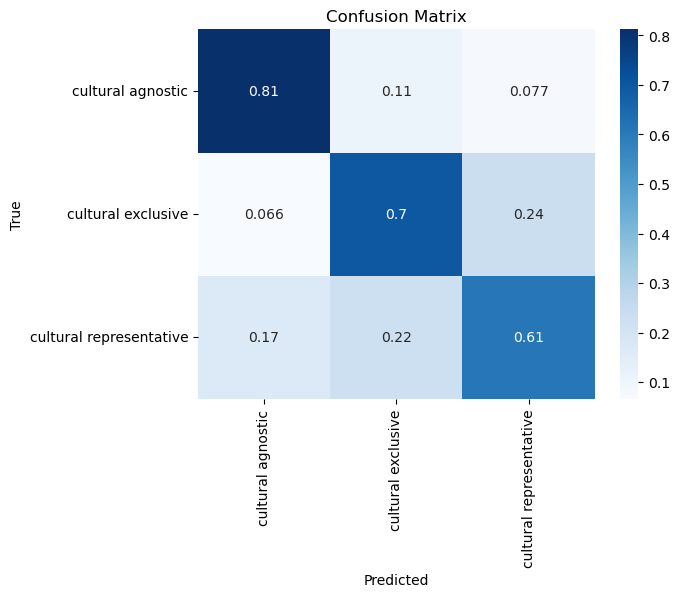

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_val, y_pred, normalize='true')
labels = np.unique(y_val)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
error_df = dev_df.copy()
error_df['true_label'] = y_val
error_df['predicted'] = y_pred
error_df['correct'] = error_df['true_label'] == error_df['predicted']

mistakes = error_df[~error_df['correct']]

mistakes[['name', 'paragraph', 'true_label', 'predicted']].sample(20, random_state=42)

,name,paragraph,true_label,predicted
259,space rock,Space rock is a music genre characterized by l...,cultural representative,cultural agnostic
0,1. FC Nürnberg,1. Fußball-Club Nürnberg Verein für Leibesübun...,cultural representative,cultural exclusive
100,European political party,"A European political party , formerly known as...",cultural representative,cultural agnostic
83,Dato Sri Tahir,"Dato' Sri Tahir , born Ang Tjoen Ming ( Chines...",cultural representative,cultural exclusive
46,Boomerang,Boomerang is an American cable television netw...,cultural exclusive,cultural representative
231,rigaudon,"The rigaudon ( French: [ʁiɡodɔ̃, ʁiɡɔdɔ̃] , Oc...",cultural exclusive,cultural representative
38,Bauhaus Archive,The Bauhaus Archive ( German : Bauhaus-Archiv ...,cultural representative,cultural exclusive
68,community journalism,"Community journalism is locally-oriented, prof...",cultural agnostic,cultural representative
17,Anasyrma,Anasyrma ( Ancient Greek : ἀνάσυρμα ) composed...,cultural representative,cultural agnostic
237,sandalwood,Sandalwood is a class of woods from trees in t...,cultural agnostic,cultural exclusive


In [21]:
mistakes_per_label = mistakes.groupby('true_label')['predicted'].value_counts().unstack(fill_value=0)
mistakes_per_label

predicted,cultural agnostic,cultural exclusive,cultural representative
true_label,,,
cultural agnostic,0,13,9
cultural exclusive,5,0,18
cultural representative,18,24,0


In [24]:
tokens_errors = [token for doc in mistakes['paragraph'] for token in tokenize(doc)]
common_error_words = Counter(tokens_errors).most_common(50)
print("Most common words in misclassified samples:")
print(common_error_words)

Most common words in misclassified samples:
[('also', 24), ('music', 20), ('dance', 18), ('party', 18), ('world', 17), ('film', 17), ('known', 16), ('city', 15), ('used', 15), ('style', 15), ('century', 14), ('folk', 14), ('term', 13), ('time', 12), ('festival', 12), ('since', 12), ('political', 12), ('european', 12), ('german', 10), ('first', 10), ('including', 10), ('arabic', 10), ('ancient', 10), ('japan', 10), ('state', 10), ('population', 9), ('name', 9), ('work', 9), ('animation', 9), ('role', 9), ('traditional', 9), ('one', 9), ('may', 9), ('building', 9), ('london', 9), ('founded', 8), ('island', 8), ('area', 8), ('people', 8), ('greek', 8), ('art', 8), ('many', 8), ('form', 8), ('french', 8), ('network', 8), ('catholic', 8), ('church', 8), ('religion', 8), ('story', 8), ('tale', 8)]


In [25]:
errors_by_class = defaultdict(list)

for _, row in mistakes.iterrows():
    tokens = tokenize(row['paragraph'])
    errors_by_class[row['label']].extend(tokens)

all_tokens_by_class = defaultdict(list)

for _, row in dev_df.iterrows():
    tokens = tokenize(row['paragraph'])
    all_tokens_by_class[row['label']].extend(tokens)

error_rate_per_token_class = {}

for class_label in errors_by_class:
    error_counts = Counter(errors_by_class[class_label])
    total_counts = Counter(all_tokens_by_class[class_label])
    
    token_rates = {}
    for token, err_count in error_counts.items():
        total = total_counts.get(token, 1)
        token_rates[token] = [err_count / total, err_count, total]

    error_rate_per_token_class[class_label] = dict(sorted(token_rates.items(), key=lambda x: x[1][0], reverse=True))
    

In [26]:
def see_mistakes(cl, word, mistakes_vocab=error_rate_per_token_class):
    print(f"Mistakes with '{word}' on: '{cl}'")
    print(mistakes_vocab[cl][word])

classes = ['cultural agnostic', 'cultural representative', 'cultural exclusive']
for cl in classes:
    see_mistakes(cl, word='dance')

Mistakes with 'dance' on: 'cultural agnostic'
[0.5833333333333334, 7, 12]
Mistakes with 'dance' on: 'cultural representative'
[0.6666666666666666, 6, 9]
Mistakes with 'dance' on: 'cultural exclusive'
[1.0, 5, 5]


In [27]:
mistakes.groupby('category').size().sort_values(ascending=False).head(10)

category
history                    8
architecture               7
philosophy and religion    7
books                      6
media                      6
fashion                    6
politics                   6
performing arts            6
films                      5
comics and anime           5
dtype: int64

In [28]:
mistakes.groupby('subcategory').size().sort_values(ascending=False).head(10)

subcategory
construction        3
religion            3
museum              3
acting style        2
animation studio    2
government          2
film genre          2
bookstore           2
book                2
historian           2
dtype: int64